In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl

import matplotlib.cm as cm

import plotly.graph_objects as go
import plotly
from plotly.subplots import make_subplots

import warnings 
warnings.filterwarnings("ignore")

from sklearn.metrics import silhouette_score

from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler

# Clustering
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score,silhouette_score,silhouette_samples

#Data Scalling
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler,MaxAbsScaler
import datetime as dt

# for interactive visualizations
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot


pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', 40)
## Reset option remove scientific notation
# pd.reset_option('display.float_format')

# RFM Analysis


RFM Model for Customer Value:

Since our dataset is limited to the sales records, and didn´t include anothers information about our customers, we will use a RFM,*Recency, Frequency and Monetary Value, based model of customer value for finding our customer segments. The RFM model will take the transactions of a customer and calculate three important informational attributes about each customer:

- Recency: The value of how recently a customer purchased at the establishment

- Frequency: How frequent the customer’s transactions are at the establishment

- Monetary value: The Pounds in our case value of all the transactions that the customer made at the establishment


**`Recency`**

To create the recency feature variable, we need to decide the reference date for our analysis. Make use of the last transaction date **Plus One Day**. Then, we will construct the recency variable as the number of days before the reference date when a customer last made a purchase.

In [6]:
df = pd.read_csv('Online Retail II Clean.csv')
display(df.head(3), df.shape)

Invoice StockCode                          Description  Quantity  Price  \
0   489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   6.95   
1   489434    79323P                   PINK CHERRY LIGHTS        12   6.75   
2   489434    79323W                  WHITE CHERRY LIGHTS        12   6.75   

   Amount Customer ID         Country          InvoiceDate Day of Week  Date  \
0   83.40     13085.0  United Kingdom  2009-12-01 07:45:00     Tuesday     1   
1   81.00     13085.0  United Kingdom  2009-12-01 07:45:00     Tuesday     1   
2   81.00     13085.0  United Kingdom  2009-12-01 07:45:00     Tuesday     1   

  Month  Year  Day of Year  Week of Year Time Hour  Hour  
0   Dec  2009          335            48  07:45:00     7  
1   Dec  2009          335            48  07:45:00     7  
2   Dec  2009          335            48  07:45:00     7

(1003214, 17)

**Checking Info of the Data**

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003214 entries, 0 to 1003213
Data columns (total 17 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Invoice       1003214 non-null  int64  
 1   StockCode     1003214 non-null  object 
 2   Description   1003214 non-null  object 
 3   Quantity      1003214 non-null  int64  
 4   Price         1003214 non-null  float64
 5   Amount        1003214 non-null  float64
 6   Customer ID   1003214 non-null  object 
 7   Country       1003214 non-null  object 
 8   InvoiceDate   1003214 non-null  object 
 9   Day of Week   1003214 non-null  object 
 10  Date          1003214 non-null  int64  
 11  Month         1003214 non-null  object 
 12  Year          1003214 non-null  int64  
 13  Day of Year   1003214 non-null  int64  
 14  Week of Year  1003214 non-null  int64  
 15  Time Hour     1003214 non-null  object 
 16  Hour          1003214 non-null  int64  
dtypes: float64(2), int64(7), ob

**Creating The `DataFrame` for RFM**

## Recency, Frequency, Monetary `DataFrame`

**Grouping by `Customer ID` and get the last date of purchase**

In [8]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%Y-%m-%d %H:%M:%S')
df['Date Full'] = pd.to_datetime(df['InvoiceDate'].dt.strftime('%Y-%m-%d'))
df['Date Full'].max()

Timestamp('2011-12-09 00:00:00')

In [9]:
a = '2011-12-10'
last = pd.to_datetime(a, format='%Y-%m-%d')
(last - df['Date Full'].max()).days

1

In [10]:
RFM = df.groupby('Customer ID').agg({'Date Full': lambda x : (last - x.max()).days,
                                    'Invoice': lambda x : len(x),
                                    'Amount': lambda x : x.sum()})

RFM.rename(columns={'Date Full': 'Recency', 
                    'Invoice': 'Frequency', 
                    'Amount': 'Monetary'}, inplace=True)

RFM.reset_index(inplace=True)

display(RFM.head(3), RFM.shape)

Customer ID  Recency  Frequency  Monetary
0     12346.0      326         25  77352.96
1     12347.0        3        222   4921.53
2     12348.0       76         46   1658.40

(8774, 4)

**Checking Distribution and Outlier of RFM**

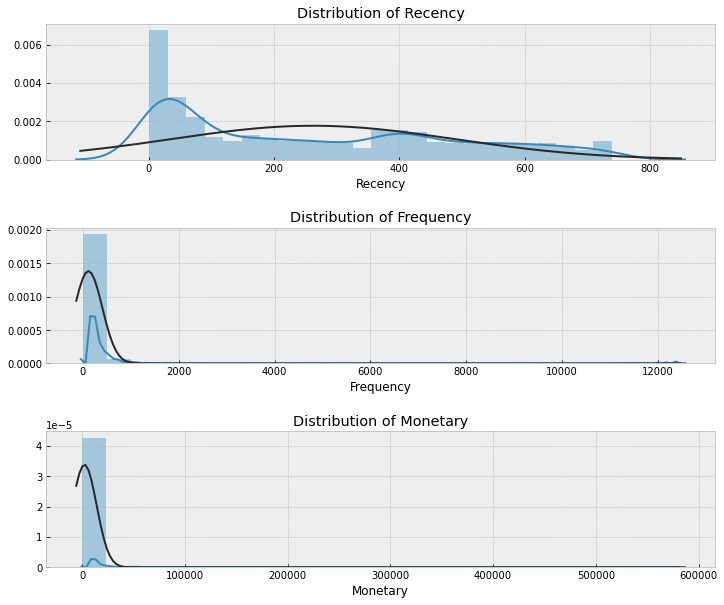

In [11]:
plt.figure(1, figsize=(12,10))

n = 0

for x in ['Recency', 'Frequency', 'Monetary']:
    plt.style.use('bmh')
    n += 1
    plt.subplot(3, 1, n)
    plt.subplots_adjust(hspace = .5, wspace = .3)
    sns.distplot(RFM[x], bins=25, fit=norm)
    plt.title(f"Distribution of {x}");

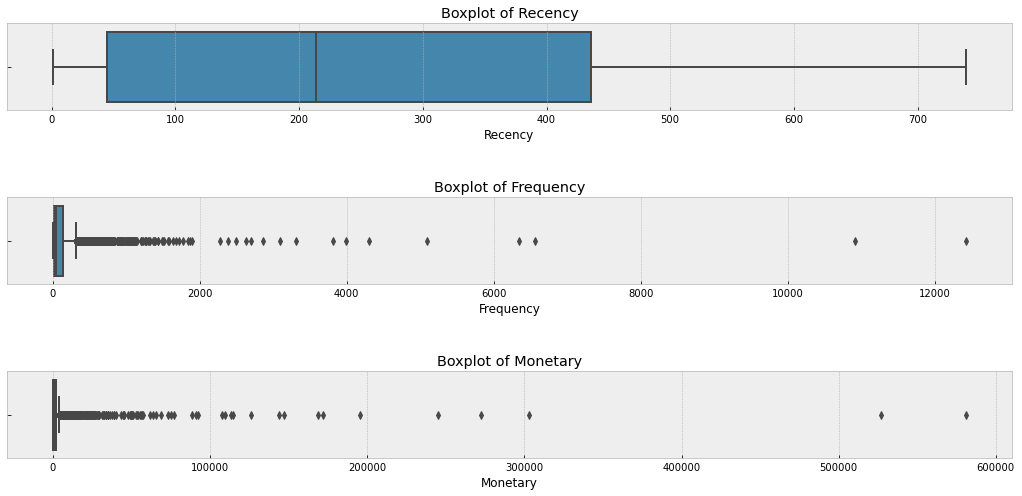

In [12]:
plt.figure(1, figsize=(18,8))

n = 0

for x in ['Recency', 'Frequency', 'Monetary']:
    plt.style.use('bmh')
    n += 1
    plt.subplot(3, 1, n)
    plt.subplots_adjust(hspace = 1)
    sns.boxplot(RFM[x])
    plt.title(f"Boxplot of {x}");

### RFM Segmentation Using Quantile Methods

* Customers with the lowest recency, highest frequency and monetary amounts considered as top customers.

In [13]:
quintiles = RFM[['Recency', 'Frequency', 'Monetary']].quantile([.25, .5, .75]).to_dict()

def r_score(x):
    if x <= quintiles['Recency'][.25]:
        return 4
    elif x <= quintiles['Recency'][.5]:
        return 3
    elif x <= quintiles['Recency'][.75]:
        return 2
    else:
        return 1
    
def fm_score(x, c):
    if x <= quintiles[c][.25]:
        return 1
    elif x <= quintiles[c][.5]:
        return 2
    elif x <= quintiles[c][.75]:
        return 3
    else:
        return 4
        
        
RFM['R'] = RFM['Recency'].apply(lambda x: r_score(x))
RFM['F'] = RFM['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
RFM['M'] = RFM['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))

RFM['RFM Score'] = RFM['R'].map(str) + RFM['F'].map(str) + RFM['M'].map(str)
RFM.head()

Customer ID  Recency  Frequency  Monetary  R  F  M RFM Score
0     12346.0      326         25  77352.96  2  2  4       224
1     12347.0        3        222   4921.53  4  4  4       444
2     12348.0       76         46   1658.40  3  3  3       333
3     12349.0       19        172   3678.69  4  4  4       444
4     12350.0      311         16    294.40  2  2  2       222

In [14]:
# Calculate RFM_Score
RFM['RFM_Sum'] = RFM[['R','F','M']].sum(axis=1)
RFM.head()

Customer ID  Recency  Frequency  Monetary  R  F  M RFM Score  RFM_Sum
0     12346.0      326         25  77352.96  2  2  4       224        8
1     12347.0        3        222   4921.53  4  4  4       444       12
2     12348.0       76         46   1658.40  3  3  3       333        9
3     12349.0       19        172   3678.69  4  4  4       444       12
4     12350.0      311         16    294.40  2  2  2       222        6

In [15]:
RFM['RFM_Sum'].describe()

count   8774.00
mean       7.49
std        2.83
min        3.00
25%        5.00
50%        8.00
75%       10.00
max       12.00
Name: RFM_Sum, dtype: float64

In [16]:
import re

In [17]:
segt_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][2-3]': 'At risk',
    r'[1-2]4': 'Can\'t loose them',
    r'2[1-2]': 'About to sleep',
    r'22': 'Need attention',
    r'[2-3][3-4]': 'Loyal customers',
    r'31': 'Promising',
    r'41': 'New customers',
    r'[3-4][1-2]': 'Potential loyalists',
    r'4[3-4]': 'Champions'
}

RFM['Segment'] = RFM['R'].map(str) + RFM['F'].map(str)
RFM['Segment'] = RFM['Segment'].replace(segt_map, regex=True)

In [18]:
segt_map

{'[1-2][1-2]': 'Hibernating',
 '[1-2][2-3]': 'At risk',
 '[1-2]4': "Can't loose them",
 '2[1-2]': 'About to sleep',
 '22': 'Need attention',
 '[2-3][3-4]': 'Loyal customers',
 '31': 'Promising',
 '41': 'New customers',
 '[3-4][1-2]': 'Potential loyalists',
 '4[3-4]': 'Champions'}

In [19]:
display(RFM.head(4), RFM.shape)

Customer ID  Recency  Frequency  Monetary  R  F  M RFM Score  RFM_Sum  \
0     12346.0      326         25  77352.96  2  2  4       224        8   
1     12347.0        3        222   4921.53  4  4  4       444       12   
2     12348.0       76         46   1658.40  3  3  3       333        9   
3     12349.0       19        172   3678.69  4  4  4       444       12   

           Segment  
0      Hibernating  
1        Champions  
2  Loyal customers  
3        Champions

(8774, 10)

In [20]:
RFM['Segment'].value_counts()

Hibernating            2931
Champions              1677
Loyal customers        1263
Potential loyalists     862
At risk                 828
Can't loose them        595
Promising               417
New customers           201
Name: Segment, dtype: int64

In [21]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = RFM.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(1)
# Print the aggregated dataset
rfm_level_agg

Recency Frequency Monetary      
                       mean      mean     mean count
Segment                                             
At risk              402.80     74.70  1337.60   828
Can't loose them     447.80    252.20  2791.40   595
Champions             17.80    315.50  7108.10  1677
Hibernating          479.50     13.90   303.00  2931
Loyal customers      109.40    153.80  2424.40  1263
New customers         21.90      6.40  1209.70   201
Potential loyalists   81.90     27.20   725.10   862
Promising            123.30      5.60   325.30   417

In [22]:
rfm_level_agg.index.tolist()

['At risk',
 "Can't loose them",
 'Champions',
 'Hibernating',
 'Loyal customers',
 'New customers',
 'Potential loyalists',
 'Promising']

In [23]:
import squarify

#### Recency and Frequency Grid
* A low recency and frequency score (bottom left) represents hibernating users who haven’t been active recently or frequently. A high recency and frequency score (top right) represents users who have been active recently and frequently, indicating your app’s champions.

* Users are then ranked in order of percentile. For example, a user who has performed the activity most recently would constitute the 100th percentile. Users are then ranked by a score of 1 through 5, based on their percentile, with 5 being the highest.

#### The Recency and Frequency Grid breaks your user base down into:

* Champions [R(4 – 5), F(4 – 5)]
* Loyal Customers [R(3 – 4), F(4 – 5)]
* Potential Loyalists [R(4 – 5), F(2 – 3)]
* Promising [R(3 – 4), F(0 – 1)]
* Can’t Lose Them [R(1 – 2), F(4 – 5)]
* At Risk [R(1 – 2), F(3 – 4)]
* About to Sleep [R(2 – 3), F(1-2)]
* Hibernating [R(1 – 2), F(1 – 2)]
* New Customers R [(4 – 5), F(0 – 1)]
* Need Attention R [(2 – 3), F(2 – 3)]

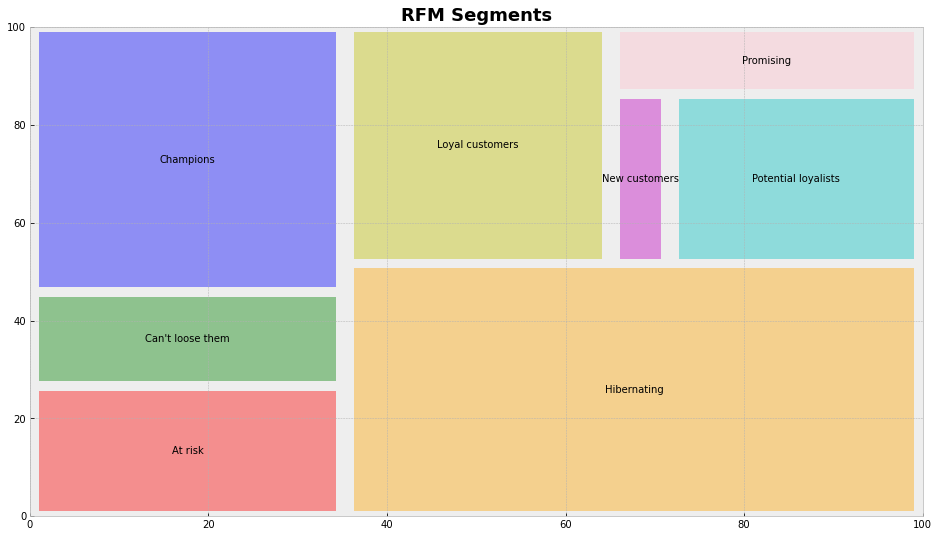

In [24]:
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=rfm_level_agg.index.tolist(), alpha=0.4, pad=0.1, color=['r', 'g', 'b', 'orange', 'y', 'm', 'c', 'pink'] )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis()
plt.savefig('RFM Segments.jpeg',
            pil_kwargs={'quality': 95,'papertype':'letter'});

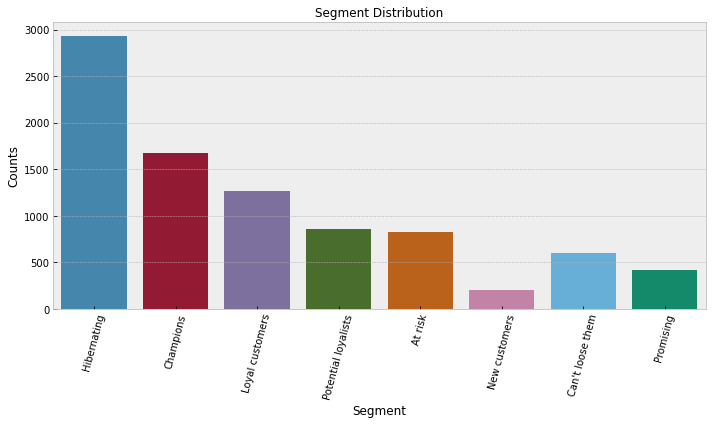

In [26]:
plt.figure(figsize=(10,6))
sns.countplot(RFM['Segment'])
plt.ylabel('Counts')
plt.xticks(rotation = 75)
plt.title('Segment Distribution', size=12)
plt.tight_layout()
plt.savefig('Distribution of Segments 2.jpeg',
            pil_kwargs={'quality': 95,'papertype':'letter'});





1. **Hibernating [R(1 – 2), F(1 – 2)]**

    - Memiliki nilai R-F score yang sangat rendah. 
         
        - Tinggi nilai Recency nya. Waktu yang lama tidak purchased online.
        
        - Rendah Frequency. Order Sedikit.
        
                Skala Prioritas : Serius
         
Perlakuan : Tawarkan produk yang relevan/similiar. Mencari customer baru akan lebih mahal ketimbang mempertahankan yang ada.


2. **At risk [R(1 – 2), F(3 – 4)]**

    - R Score rendah dan F Score sedikit lebih dari *`Hibernating`*
    
        - Tinggi nilai Recency. Waktu yang lama tidak purchased online.
        
        
        - Nilai Frequency Cukup Tinggi. Order lebih banyak ketimbang *`Hibernating*.
        
                Skala Prioritas: Serius
        
**Perlakuan : Tawarkan produk yang relevan/similiar. Mencari customer baru akan lebih mahal ketimbang mempertahankan yang ada**

3. **Cannot Lose them [R(1 – 2), F(4 – 5)]**

    - R Score Rendah dan F Score Sangat Tinggi
    
        - Nilai Recency Tinggi. Nilai Frequency Tinggi. Dalam jangka waktu yang lama tidak membeli lagi, tetapi sebelumnya frequency order nya sangat tinggi.
        
**Perlakuan: Komunikasikan kembali dengan customer, rekomendasi produk relevan yang pernah dibeli. Ataupun reward untuk dari transaksi**
4. **New Customers [R(4 – 5), F(0 – 1)]**

    - R Score Sangat tinggi/Value Rendah, F Score sangat rendah
    
        - Dalam jangka waktu yang tidak terlalu lama baru saja melakukan purchased online tetapi tidak frekuen.

**Perlakuan: Tawarkan produk populer dan Diskon dalam bundling**

5. **Need atention [R(2 – 3), F(2 – 3)]**

    - R dan F Score tengah-tengah
        
        - Tidak terlalu dalam jangka waktu dalam terakhir purchased, dan tidak tidak begitu frekuen dalam purchasing.
        
**Perlakuan: Memberi katalog produk yang ada atau produk yang sering dibeli oleh customer segment lain** 

6. **Loyal Customer [R(3 – 4), F(4 – 5)]**

    - R Score cukup tinggi dan F Score sangat Tinggi
    
        - Dalam waktu jangka pendek baru saja melakukan purchase online dan sering purchased online
        
**Perlakuan: Melakuan promosi dan bundling product**

7. **Promising new customer [R(3 – 4), F(0 – 1)]**

    - R Score Cukup Tinggi dan F Score Sangat Rendah
    
        - Dalam jangka waktu pendek melakukan purchased online. Dan jarang sekali purchase online. Artinya menjanjikan untuk menjadi new customer.

**Perlakuannya: Customer first buyer. Lihat dulu behavioural purchased. Recommender System**

8. Potential loyalist [R(4 – 5), F(2 – 3)]

    - R Score cukup tinggi dan F Score berada di tengah-tengah.
    
        - Frequency purchase online berada di tengah-tengah tetapi baru saja menjadi customer
        
**Perlakuannya: Berpotensial untuk sangat loyal dengan frequency cukup tinggi. Beri promosi pada produk yang disukai, ataupun membership dan system rekomendasi.

9. **Champions [R(4 – 5), F(4 – 5)]**

    - Juara dalam waktu dan seringnya pembelian

**Perlakuannya:Kelas VVIP ataupun perlakuan lebih untuk mempermudah belanja online.**

# K-Means Clustering

## Normal No Scaler

In [27]:
rfm_kmeans = RFM[['Recency','Frequency', 'Monetary']]

### K-Values and Clustering

In [28]:
k = range(1, 15)
inertia = []

for i in k:
    model = KMeans(n_clusters = i)
    model.fit(rfm_kmeans)
    inertia.append(model.inertia_)

print(k)
print(inertia)

range(1, 15)
[1223104275861.8733, 475329959179.3048, 236060817501.4877, 130791008685.29712, 80314693399.93811, 50678043409.58033, 35091926290.94575, 25792646643.858234, 18941818093.72095, 15865849700.635107, 13694782531.749598, 12186902293.442131, 11097402436.461126, 8919979304.198444]


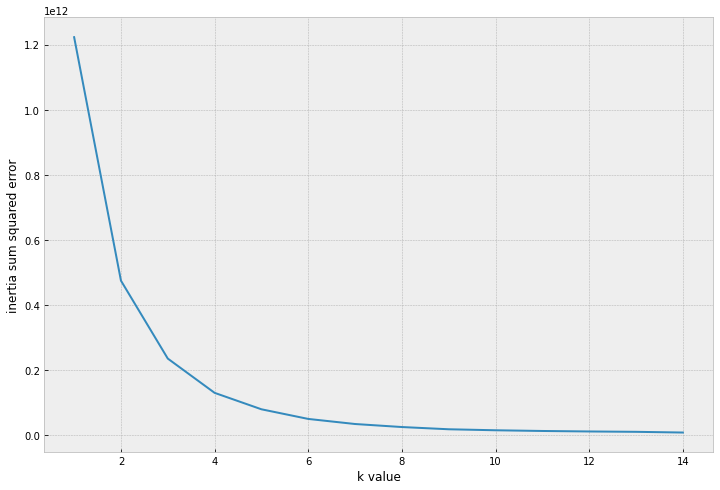

In [29]:
plt.figure(figsize=(12,8))
plt.plot(k, inertia) # Untuk melihat pada sikut dalam plot
plt.xlabel('k value')
plt.ylabel('inertia sum squared error');

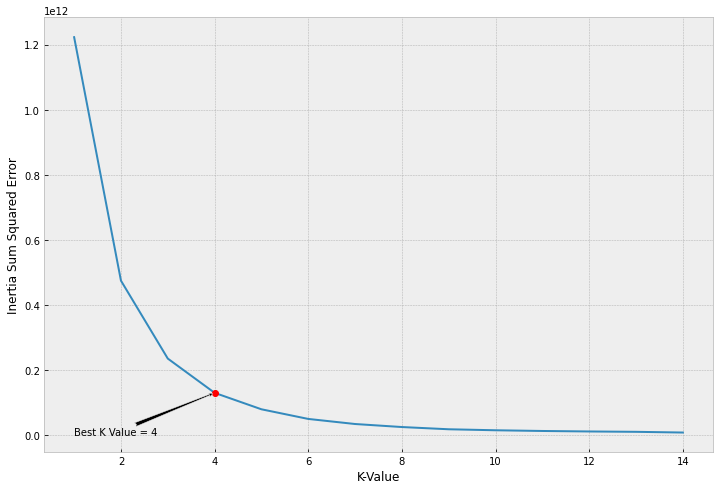

In [30]:
plt.figure(figsize=(12,8))
plt.plot(k, inertia)
plt.xlabel('K-Value')
plt.ylabel('Inertia Sum Squared Error')
plt.plot(k[3], inertia[3], 'ro')
plt.annotate(
    'Best K Value = 4', xy=(k[3], inertia[3]),
    xytext = (1, 20), arrowprops = dict(arrowstyle='fancy',facecolor='black'));

### Using 4 Cluster

In [31]:
kmeans = KMeans(n_clusters = 4, init='k-means++', n_init=100, max_iter=10000, algorithm='full')
kmeans.fit(rfm_kmeans)
pred = kmeans.predict(rfm_kmeans)

In [32]:
pred

array([2, 0, 0, ..., 0, 0, 0])

In [33]:
np.unique(kmeans.labels_)

array([0, 1, 2, 3])

### Silhouette Score

In [34]:
from sklearn.metrics import silhouette_score
score = silhouette_score(rfm_kmeans, kmeans.labels_)
print("Silhoutte Score = ", round(score,2)*100, '%')

Silhoutte Score =  95.0 %


In [35]:
db,slc = {}, {}
for k in range(2, 8):
    # seed of 10 for reproducibility.
    kmeans_normal = KMeans(n_clusters=k, init='k-means++' ,max_iter=10000,random_state=42).fit(rfm_kmeans)
    clusters = kmeans_normal.labels_
    db[k] = davies_bouldin_score(rfm_kmeans,clusters)
    slc[k] = silhouette_score(rfm_kmeans,clusters)

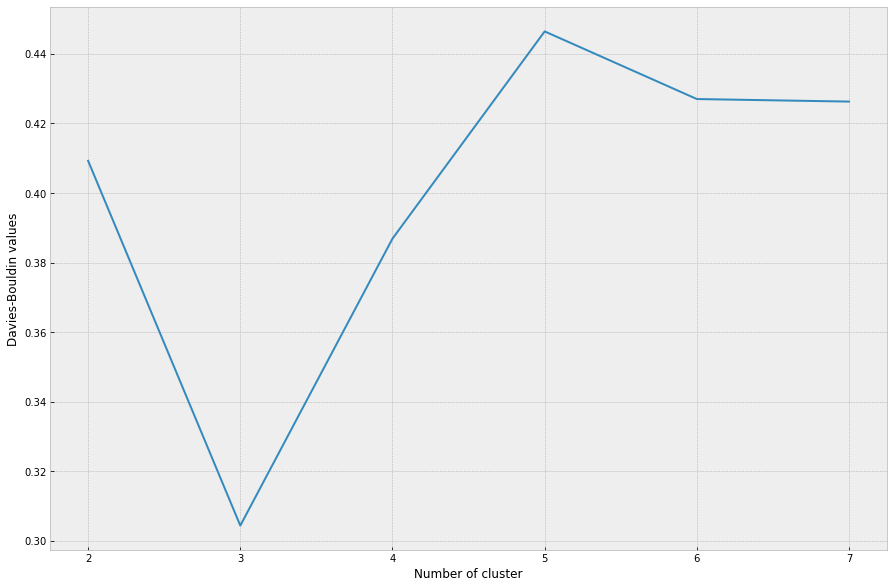

In [36]:
plt.figure(figsize=(15,10))
plt.plot(list(db.keys()), list(db.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Davies-Bouldin values")
plt.show()

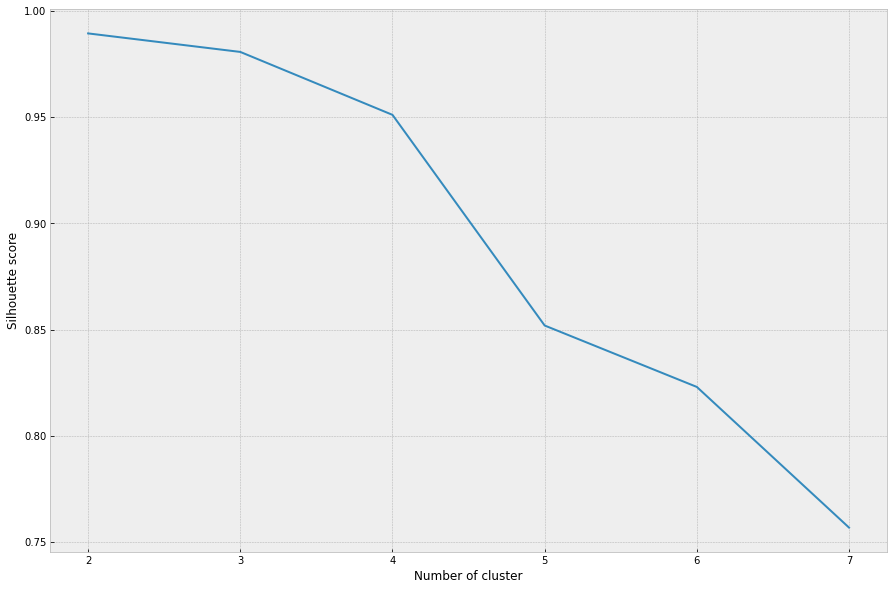

In [37]:
plt.figure(figsize=(15,10))
plt.plot(list(slc.keys()), list(slc.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette score")
plt.show()

In [38]:
pd.Series(pred).value_counts()

0    8710
2      54
3       8
1       2
dtype: int64

It Doesn't Make sense to clustering like that.

## Scaling Log

### K-Values and Clustering

In [39]:
cols = ['Recency', 'Frequency', 'Monetary']

#Generate Feature of Logged value for each Recency, Frequency, and Monetary
for i in cols :
    rfm_kmeans[f'{i}LS'] = np.log(rfm_kmeans[i])

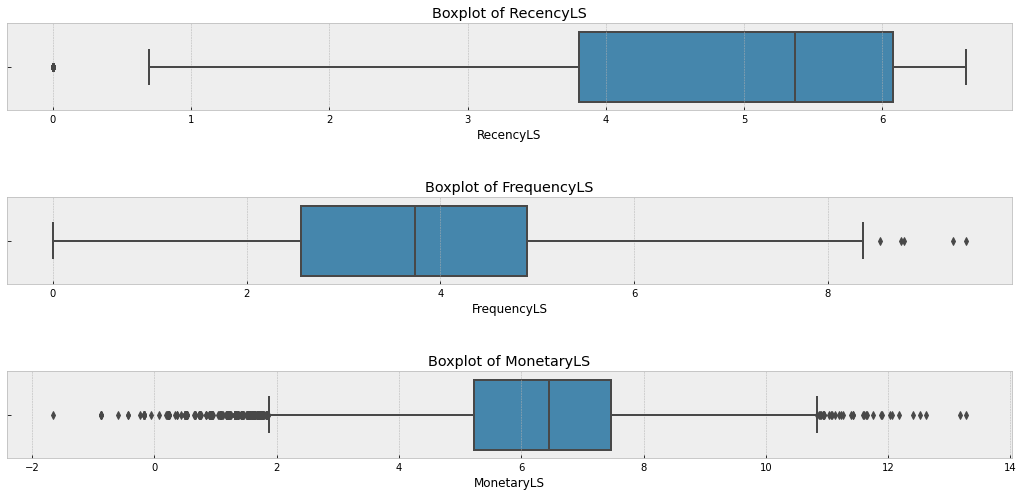

In [40]:
plt.figure(1, figsize=(18,8))

n = 0

for x in ['RecencyLS', 'FrequencyLS', 'MonetaryLS']:
    plt.style.use('bmh')
    n += 1
    plt.subplot(3, 1, n)
    plt.subplots_adjust(hspace = 1)
    sns.boxplot(rfm_kmeans[x])
    plt.title(f"Boxplot of {x}");

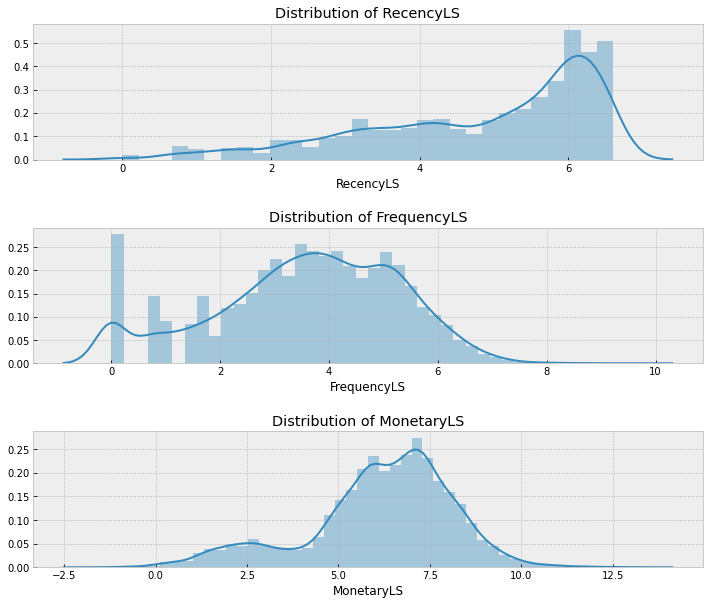

In [41]:
plt.figure(1, figsize=(12,10))

n = 0

for x in ['RecencyLS', 'FrequencyLS', 'MonetaryLS']:
    plt.style.use('bmh')
    n += 1
    plt.subplot(3, 1, n)
    plt.subplots_adjust(hspace = .5, wspace = .3)
    sns.distplot(rfm_kmeans[x])
    plt.title(f"Distribution of {x}");

### Elbow Methods

In [42]:
rfm_kmeans_log = rfm_kmeans[['RecencyLS','FrequencyLS','MonetaryLS']]

In [43]:
k = range(1, 15)
inertia = []

for i in k:
    model = KMeans(n_clusters = i, init='k-means++' ,max_iter=10000,random_state=42)
    model.fit(rfm_kmeans_log)
    inertia.append(model.inertia_)

print(k)
print(inertia)

range(1, 15)
[81261.92969082331, 41029.937378364746, 27078.41999310665, 20468.47505469159, 16547.65634183883, 14668.699103201614, 13175.607432256264, 12070.912822687242, 11122.346529982055, 10274.638796977597, 9665.241149047095, 9128.712412362935, 8664.448992268832, 8247.504981233988]


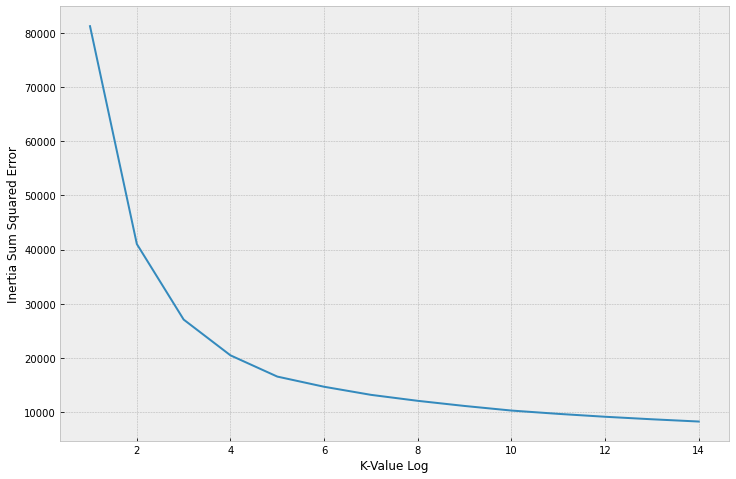

In [44]:
plt.figure(figsize=(12,8))
plt.plot(k, inertia) # Untuk melihat pada sikut dalam plot
plt.xlabel('K-Value Log')
plt.ylabel('Inertia Sum Squared Error');

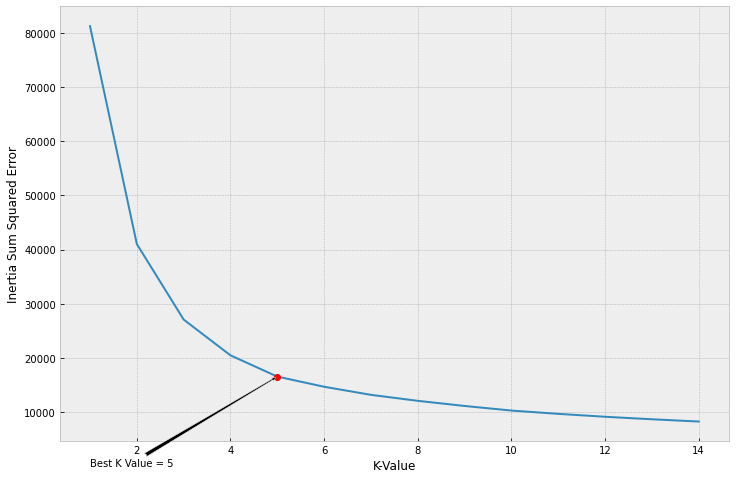

In [45]:
plt.figure(figsize=(12,8))
plt.plot(k, inertia)
plt.xlabel('K-Value')
plt.ylabel('Inertia Sum Squared Error')
plt.plot(k[4], inertia[4], 'ro')
plt.annotate(
    'Best K Value = 5', xy=(k[4], inertia[4]),
    xytext = (1, 20), arrowprops = dict(arrowstyle='fancy',facecolor='black'));

### Silhouette Score

In [46]:
db,slc = {}, {}
for k in range(2, 8):
    # seed of 10 for reproducibility.
    kmeans_logshil = KMeans(n_clusters=k, init='k-means++' ,max_iter=10000,random_state=42).fit(rfm_kmeans_log)
    clusters = kmeans_logshil.labels_
    db[k] = davies_bouldin_score(rfm_kmeans_log,clusters)
    slc[k] = silhouette_score(rfm_kmeans_log,clusters)

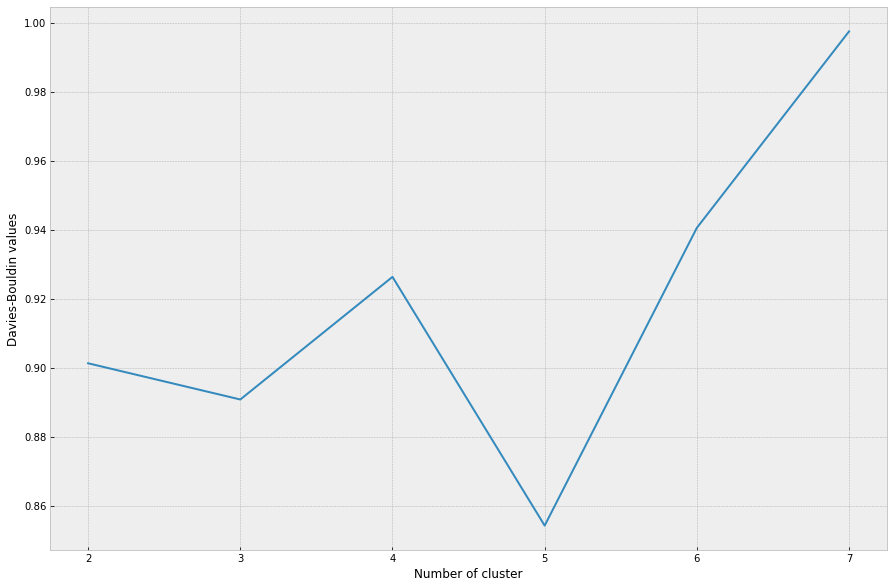

In [47]:
plt.figure(figsize=(15,10))
plt.plot(list(db.keys()), list(db.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Davies-Bouldin values")
plt.show()

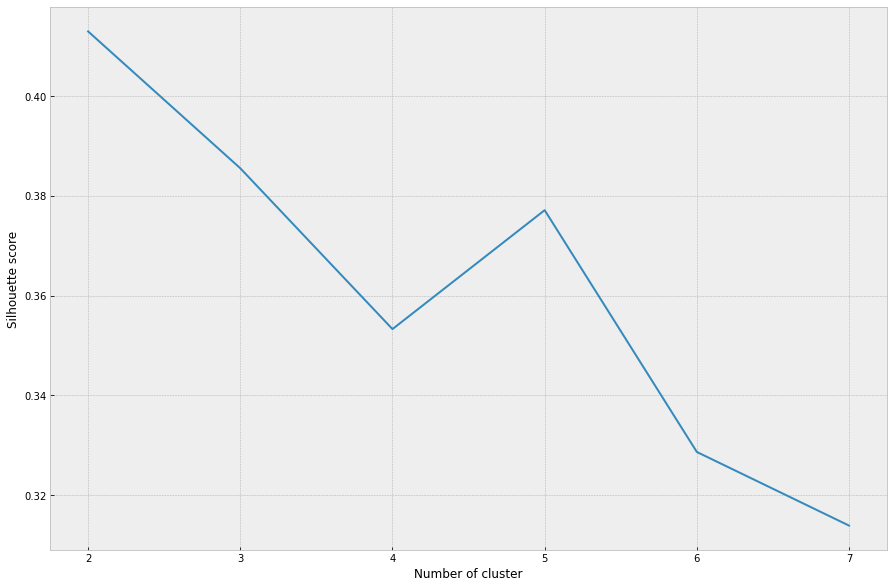

In [48]:
plt.figure(figsize=(15,10))
plt.plot(list(slc.keys()), list(slc.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette score")
plt.show()

### Using 5 Cluster

In [49]:
kmeans_log = KMeans(n_clusters = 5, random_state=42)
kmeans_log.fit(rfm_kmeans_log)
pred_scaler_log = kmeans_log.predict(rfm_kmeans_log)

In [50]:
np.unique(kmeans_log.labels_)

array([0, 1, 2, 3, 4])

In [51]:
pd.Series(pred_scaler_log).value_counts()

2    2496
0    2280
3    1393
1    1368
4    1237
dtype: int64

In [52]:
rfm_kmeans_log['ClusterLog'] = pred_scaler_log
rfm_kmeans_log.head()

RecencyLS  FrequencyLS  MonetaryLS  ClusterLog
0       5.79         3.22       11.26           0
1       1.10         5.40        8.50           3
2       4.33         3.83        7.41           0
3       2.94         5.15        8.21           3
4       5.74         2.77        5.68           2

In [53]:
RFM = RFM.join(rfm_kmeans_log)

In [54]:
RFM.to_csv('RFM and Clustering.csv', index=False)

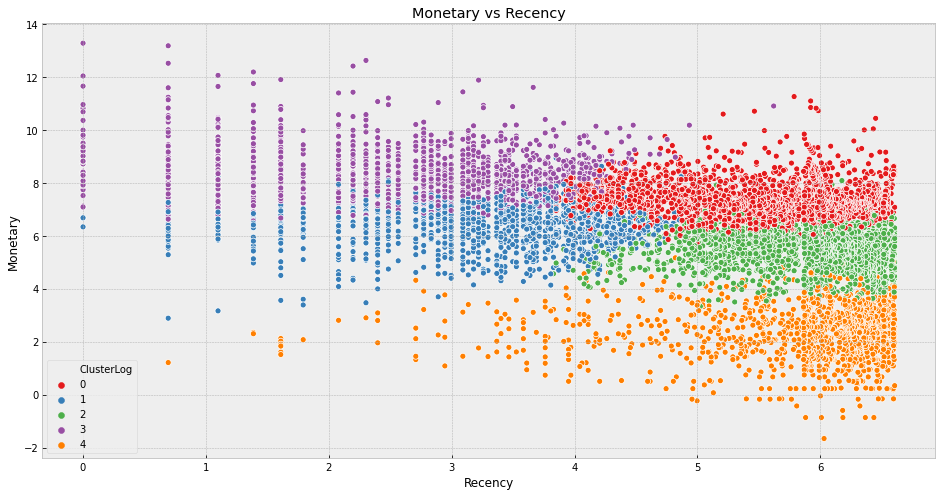

In [55]:
plt.figure(figsize=(16,8))
sns.scatterplot(x='RecencyLS', y='MonetaryLS', data=rfm_kmeans_log, hue='ClusterLog', palette='Set1', ci=None)
plt.ylabel('Monetary')
plt.xlabel('Recency')
plt.title('Monetary vs Recency');

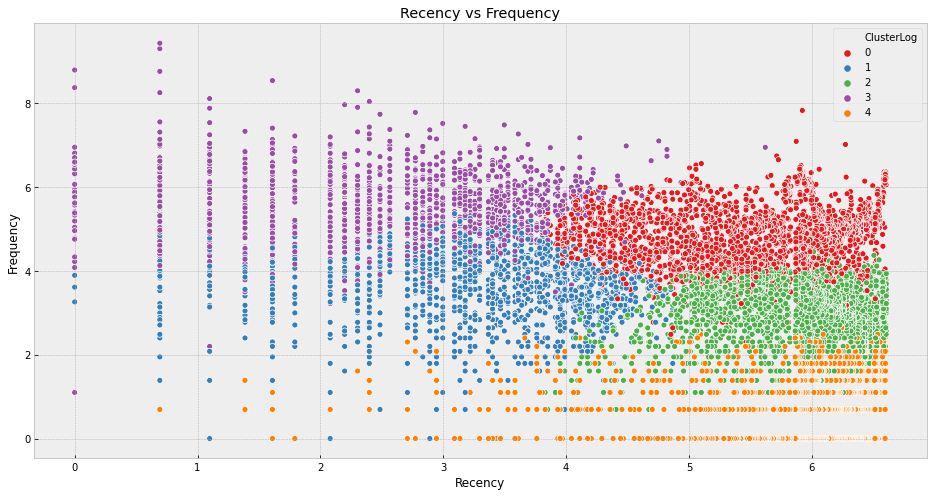

In [56]:
plt.figure(figsize=(16,8))
sns.scatterplot(x='RecencyLS', y='FrequencyLS', data=rfm_kmeans_log, hue='ClusterLog', palette='Set1', ci=None)
plt.ylabel('Frequency')
plt.xlabel('Recency')
plt.title('Recency vs Frequency');

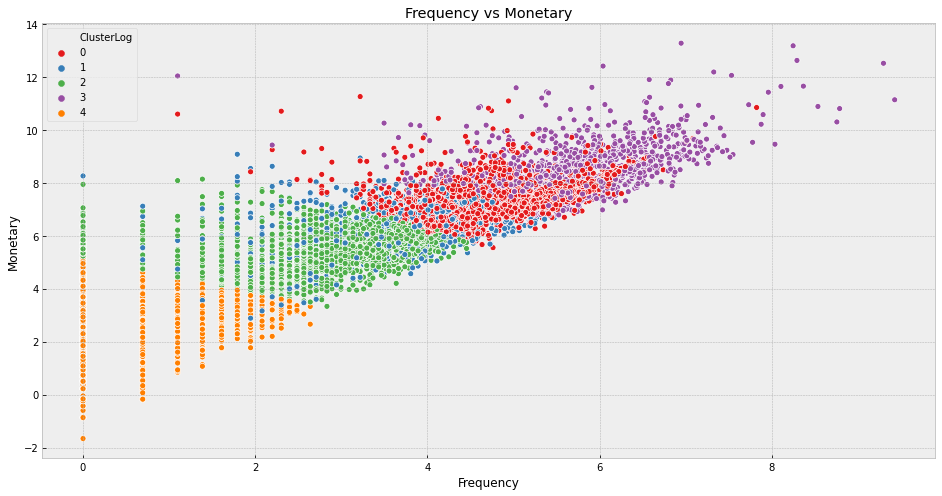

In [57]:
plt.figure(figsize=(16,8))
sns.scatterplot(x='FrequencyLS', y='MonetaryLS', data=rfm_kmeans_log, hue='ClusterLog', palette='Set1', ci=None)
plt.ylabel('Monetary')
plt.xlabel('Frequency')
plt.title('Frequency vs Monetary');

In [58]:
trace1 = go.Scatter3d(
    x= rfm_kmeans_log['RecencyLS'],
    y= rfm_kmeans_log['FrequencyLS'],
    z= rfm_kmeans_log['MonetaryLS'],
    mode='markers',
     marker=dict(
        color = rfm_kmeans_log['ClusterLog'], 
        size= 4,
        line=dict(
            color= rfm_kmeans_log['ClusterLog'],
            width= 20
        ),
        opacity=0.6
     )
)
tf = [trace1]

layout = go.Layout(autosize=True,
    title = 'Recency vs Frequency vs Monetary',
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0  
    ),
    scene = dict(
            xaxis = dict(title  = 'Recency'),
            yaxis = dict(title  = 'Frequency'),
            zaxis = dict(title  = 'Monetary')
        )
)

fig = go.Figure(data = tf, layout = layout)
py.iplot(fig)

In [59]:
from mpl_toolkits.mplot3d import Axes3D

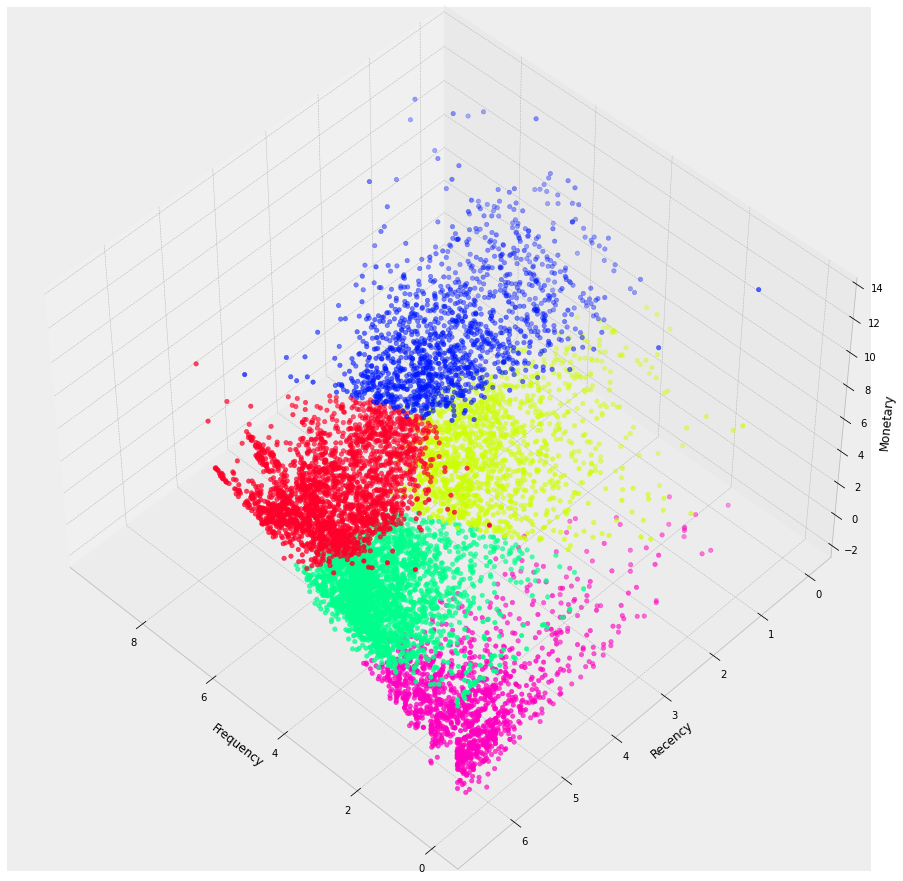

In [60]:
l = kmeans_log.labels_
fig = plt.figure(1, figsize=(18,12), facecolor='w')
plt.clf()
ax = Axes3D(fig, rect=[0,0,.95,1], elev=48, azim=134)
plt.cla()
ax.set_xlabel('Frequency')
ax.set_ylabel('Recency')
ax.set_zlabel('Monetary')

clusplot = ax.scatter(rfm_kmeans_log.loc[:,'FrequencyLS'], 
           rfm_kmeans_log.loc[:,'RecencyLS'], 
           rfm_kmeans_log.loc[:,'MonetaryLS'], c =l.astype(np.float), cmap = 'gist_rainbow')
clusplot.fig_save;

In [61]:
import plotly.express as px

In [71]:
px.scatter_3d(RFM,x='RecencyLS',y='FrequencyLS',z='MonetaryLS',
              color='ClusterLog', color_continuous_scale='rainbow',size='RFM_Sum', size_max=10,
              width=800, height=650)
# fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

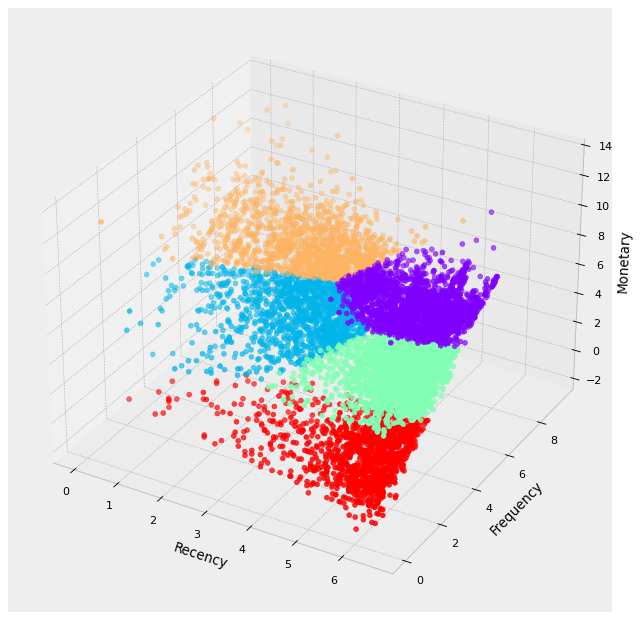

In [73]:
fig = plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")

ax.scatter3D(RFM['RecencyLS'],RFM['FrequencyLS'],RFM['MonetaryLS'],c=RFM['ClusterLog'], cmap='rainbow')

xLabel = ax.set_xlabel('Recency', linespacing=3.2)
yLabel = ax.set_ylabel('Frequency', linespacing=3.1)
zLabel = ax.set_zlabel('Monetary', linespacing=3.4)

plt.savefig('3D Bored Scatter Cluster.jpeg',pil_kwargs={'quality': 95,'papertype':'letter'})
# print("K-MEANS")
# fig.savefig('3d.png')

In [63]:
cluster = df.merge(RFM, on='Customer ID')
display(cluster.head(3), cluster.shape)

Invoice StockCode                          Description  Quantity  Price  \
0   489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   6.95   
1   489434    79323P                   PINK CHERRY LIGHTS        12   6.75   
2   489434    79323W                  WHITE CHERRY LIGHTS        12   6.75   

   Amount Customer ID         Country         InvoiceDate Day of Week  Date  \
0   83.40     13085.0  United Kingdom 2009-12-01 07:45:00     Tuesday     1   
1   81.00     13085.0  United Kingdom 2009-12-01 07:45:00     Tuesday     1   
2   81.00     13085.0  United Kingdom 2009-12-01 07:45:00     Tuesday     1   

  Month  Year  Day of Year  Week of Year Time Hour  Hour  Date Full  Recency  \
0   Dec  2009          335            48  07:45:00     7 2009-12-01      158   
1   Dec  2009          335            48  07:45:00     7 2009-12-01      158   
2   Dec  2009          335            48  07:45:00     7 2009-12-01      158   

   Frequency  Monetary  R  F  M RFM Score  RFM_Sum          Segment  \
0         84   2433.28  3  3  4       334       10  Loyal customers   
1         84   2433.28  3  3  4       334       10  Loyal customers   
2         84   2433.28  3  3  4       334       10  Loyal customers   

   RecencyLS  FrequencyLS  MonetaryLS  ClusterLog  
0       5.06         4.43        7.80           0  
1       5.06         4.43        7.80           0  
2       5.06         4.43        7.80           0

(1003214, 31)

In [64]:
cluster['ClusterLog'].replace({0:'Cluster A', 
                               1:'Cluster B',
                               2:'Cluster C', 
                               3:'Cluster D',
                               4:'Cluster E'}, inplace=True)

In [65]:
display(cluster.head(3), cluster.shape)

Invoice StockCode                          Description  Quantity  Price  \
0   489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   6.95   
1   489434    79323P                   PINK CHERRY LIGHTS        12   6.75   
2   489434    79323W                  WHITE CHERRY LIGHTS        12   6.75   

   Amount Customer ID         Country         InvoiceDate Day of Week  Date  \
0   83.40     13085.0  United Kingdom 2009-12-01 07:45:00     Tuesday     1   
1   81.00     13085.0  United Kingdom 2009-12-01 07:45:00     Tuesday     1   
2   81.00     13085.0  United Kingdom 2009-12-01 07:45:00     Tuesday     1   

  Month  Year  Day of Year  Week of Year Time Hour  Hour  Date Full  Recency  \
0   Dec  2009          335            48  07:45:00     7 2009-12-01      158   
1   Dec  2009          335            48  07:45:00     7 2009-12-01      158   
2   Dec  2009          335            48  07:45:00     7 2009-12-01      158   

   Frequency  Monetary  R  F  M RFM Score  RFM_Sum          Segment  \
0         84   2433.28  3  3  4       334       10  Loyal customers   
1         84   2433.28  3  3  4       334       10  Loyal customers   
2         84   2433.28  3  3  4       334       10  Loyal customers   

   RecencyLS  FrequencyLS  MonetaryLS ClusterLog  
0       5.06         4.43        7.80  Cluster A  
1       5.06         4.43        7.80  Cluster A  
2       5.06         4.43        7.80  Cluster A

(1003214, 31)

In [61]:
cluster.to_csv('Clustering All.csv', index=False)